In [110]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [111]:
# Read excel file in variable
df = pd.read_excel(r'C:\Users\tom.rigter\PPAnalytics\EPEXSPOT.xlsx')
df = df.dropna()
df.head()

,Date,Time,EPEX_SPOT_NL
0,2015-01-01,00:00:00,38.50
1,2015-01-01,01:00:00,38.22
2,2015-01-01,02:00:00,35.60
3,2015-01-01,03:00:00,33.00
4,2015-01-01,04:00:00,27.41


In [112]:
# Convert columns so they can be merged and indexed
df['Date'] = df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['Time'] = df['Time'].apply(lambda x: x.strftime('%H:%M:%S'))
df.index = pd.to_datetime(df['Date'] + " " + df['Time'], format='%Y-%m-%d %H:%M:%S')

,EPEX_SPOT_NL
count,63043.000000
mean,52.738938
std,47.526811
min,-79.190000
25%,31.520000
50%,40.370000
75%,53.520000
max,700.000000


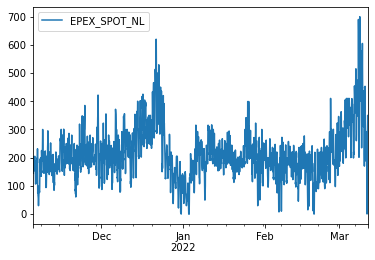

In [113]:
# Plot and properties of dataframe
df[60000:].plot(y='EPEX_SPOT_NL', use_index=True)
df.describe()

In [114]:
# Define seasonality columns
df['Hour'] = df.index.hour
df['Weekday'] = df.index.dayofweek
df['Month'] = df.index.month

In [115]:
df.head()

,Date,Time,EPEX_SPOT_NL,Hour,Weekday,Month
2015-01-01 00:00:00,2015-01-01,00:00:00,38.50,0,3,1
2015-01-01 01:00:00,2015-01-01,01:00:00,38.22,1,3,1
2015-01-01 02:00:00,2015-01-01,02:00:00,35.60,2,3,1
2015-01-01 03:00:00,2015-01-01,03:00:00,33.00,3,3,1
2015-01-01 04:00:00,2015-01-01,04:00:00,27.41,4,3,1


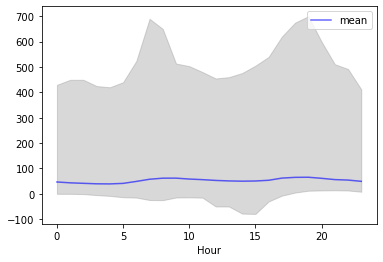

In [116]:
# Plot hourly data
hourly_data = df.groupby('Hour')['EPEX_SPOT_NL'].agg(['min','max','mean'])
hourly_data.reset_index(inplace=True)

ax  = hourly_data.plot(x='Hour', y='mean', c='blue', alpha=0.6)
plt.fill_between(x='Hour',y1='min',y2='max', data=hourly_data, color='grey', alpha=0.3)

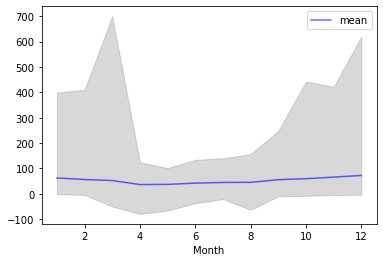

In [117]:
# Plot monthly data
monthly_data = df.groupby('Month')['EPEX_SPOT_NL'].agg(['min','max','mean'])
monthly_data.reset_index(inplace=True)

ax  = monthly_data.plot(x='Month', y='mean', c='blue', alpha=0.6)
plt.fill_between(x='Month',y1='min',y2='max', data=monthly_data, color='grey', alpha=0.3)

<AxesSubplot:ylabel='EPEX_SPOT_NL'>

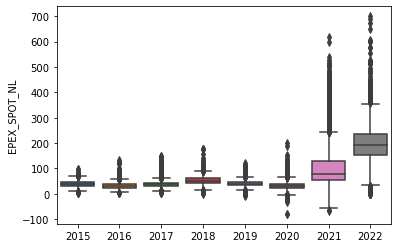

In [118]:
# Plot yearly data
sns.boxplot(x=df.index.year, y='EPEX_SPOT_NL', data=df)

In [119]:
# normalization of data
values = df['EPEX_SPOT_NL'].values
values = values.reshape((-1, 1))

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f,Max: %f' % (scaler.data_min_, scaler.data_max_))

normalized = scaler.transform(values)
df['Normalized EPEX'] = normalized

Min: -79.190000,Max: 700.000000


In [120]:
# Function for processing DataFrame to array for LSTM model
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_xy(df, window_size=5):
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(x), np.array(y) 

In [121]:
# pre-process data for LSTM
WINDOWSIZE = 5
temp = df['Normalized EPEX']
x, y = df_to_xy(temp, WINDOWSIZE)
x.shape, y.shape

((63038, 5, 1), (63038,))

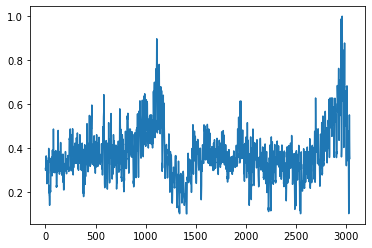

In [122]:
# split data in train- and testset
x_train, y_train = x[:55000],y[:55000]
x_val, y_val = x[55000:60000],y[55000:60000]
x_test, y_test = x[60000:],y[60000:]

plt.plot(y_test)

In [123]:
# LSTM model with 3 layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model_1 = Sequential()
model_1.add(InputLayer((5, 1)))
model_1.add(LSTM(64))
model_1.add(Dense(8))
model_1.add(Dense(1))
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [124]:
cp = ModelCheckpoint('model_1/', save_best_only=True)
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [125]:
model_1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
1716/1719 [============================>.] - ETA: 0s - loss: 7.9895e-04 - root_mean_squared_error: 0.0283

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 28s 14ms/step - loss: 7.9813e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 2/10
1714/1719 [============================>.] - ETA: 0s - loss: 1.7754e-04 - root_mean_squared_error: 0.0133

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 32s 19ms/step - loss: 1.7749e-04 - root_mean_squared_error: 0.0133 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 3/10
1706/1719 [============================>.] - ETA: 0s - loss: 1.4961e-04 - root_mean_squared_error: 0.0122

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 22s 13ms/step - loss: 1.4940e-04 - root_mean_squared_error: 0.0122 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 4/10
1713/1719 [============================>.] - ETA: 0s - loss: 1.2379e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 15s 9ms/step - loss: 1.2381e-04 - root_mean_squared_error: 0.0111 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 5/10
1715/1719 [============================>.] - ETA: 0s - loss: 9.7171e-05 - root_mean_squared_error: 0.0099

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 18s 11ms/step - loss: 9.7156e-05 - root_mean_squared_error: 0.0099 - val_loss: 8.2228e-04 - val_root_mean_squared_error: 0.0287
Epoch 6/10
1709/1719 [============================>.] - ETA: 0s - loss: 7.7800e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 18s 11ms/step - loss: 7.7837e-05 - root_mean_squared_error: 0.0088 - val_loss: 6.3172e-04 - val_root_mean_squared_error: 0.0251
Epoch 7/10
1708/1719 [============================>.] - ETA: 0s - loss: 6.9895e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 17s 10ms/step - loss: 6.9904e-05 - root_mean_squared_error: 0.0084 - val_loss: 6.1132e-04 - val_root_mean_squared_error: 0.0247
Epoch 8/10
1713/1719 [============================>.] - ETA: 0s - loss: 6.4605e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 17s 10ms/step - loss: 6.4561e-05 - root_mean_squared_error: 0.0080 - val_loss: 5.4915e-04 - val_root_mean_squared_error: 0.0234
Epoch 9/10
1712/1719 [============================>.] - ETA: 0s - loss: 6.0995e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 17s 10ms/step - loss: 6.0961e-05 - root_mean_squared_error: 0.0078 - val_loss: 4.8487e-04 - val_root_mean_squared_error: 0.0220
Epoch 10/10
1713/1719 [============================>.] - ETA: 0s - loss: 5.8898e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 17s 10ms/step - loss: 5.8950e-05 - root_mean_squared_error: 0.0077 - val_loss: 4.3303e-04 - val_root_mean_squared_error: 0.0208


In [126]:
from tensorflow.keras.models import load_model

model_1 = load_model('model_1/')

1719/1719 [==============================] - 4s 2ms/step


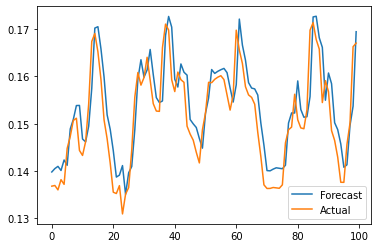

In [127]:
# plot trained data & actuals
train_predictions = model_1.predict(x_train).flatten()
train_results = pd.DataFrame(data={'train predictions':train_predictions, 'actuals':y_train})
plt.plot(train_results['train predictions'][:100], label="Forecast")
plt.plot(train_results['actuals'][:100], label="Actual")
plt.legend()
plt.show()

95/95 [==============================] - 1s 7ms/step


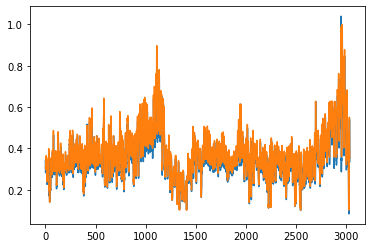

In [128]:
# plot trained data & actuals
test_predictions = model_1.predict(x_test).flatten()
test_results = pd.DataFrame(data={'test predictions':test_predictions, 'actuals':y_test})
plt.plot(test_results['test predictions'])
plt.plot(test_results['actuals'])
plt.show()

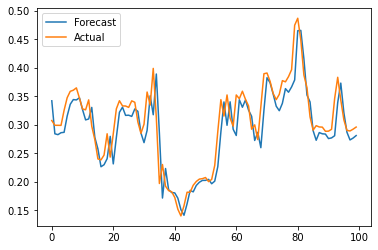

In [129]:
# plot trained data & actuals (first 100)
plt.plot(test_results['test predictions'][:100], label="Forecast")
plt.plot(test_results['actuals'][:100], label="Actual")
plt.legend()
plt.show()

In [139]:
# Predict the first 5 hours in the future 
future_data = df['Normalized EPEX'].values.reshape((-1))

def predict(num_prediction, model):
    prediction_list = future_data[-WINDOWSIZE:]
    
    for _ in range(num_prediction):
        x = prediction_list[-WINDOWSIZE:]
        x = x.reshape((1, WINDOWSIZE, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[WINDOWSIZE-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1, freq='H').tolist()
    return prediction_dates

num_prediction = 5
forecast = predict(num_prediction, model_1)
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 32ms/step


In [140]:
#
forecast_dates

[Timestamp('2022-03-11 23:00:00', freq='H'),
 Timestamp('2022-03-12 00:00:00', freq='H'),
 Timestamp('2022-03-12 01:00:00', freq='H'),
 Timestamp('2022-03-12 02:00:00', freq='H'),
 Timestamp('2022-03-12 03:00:00', freq='H'),
 Timestamp('2022-03-12 04:00:00', freq='H')]